# Лабораторная работа №4 

## Ишков Денис Олегович, ИУ5-24М, 2021г.

## Тема: Создание рекомендательной модели
## Цель: Изучение разработки рекомендательных моделей.
Требования к отчету:
Отчет по лабораторной работе должен содержать:
* титульный лист;
* описание задания;
* текст программы;
* экранные формы с примерами выполнения программы.

Задание:

* Выбрать произвольный набор данных (датасет), предназначенный для построения рекомендательных моделей.
* Опираясь на материалы лекции, сформировать рекомендации для одного пользователя (объекта) двумя произвольными способами.
* Сравнить полученные рекомендации (если это возможно, то с применением метрик).

## Датасет

Игры Steam

https://www.kaggle.com/tamber/steam-video-games/data

In [1]:
# загрузка датасета
!pip install wldhx.yadisk-direct
!curl -L $(yadisk-direct https://disk.yandex.ru/d/pImR-9hIQst3fg) -o steam.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 8748k  100 8748k    0     0  1278k      0  0:00:06  0:00:06 --:--:-- 1804k


# Импорт нужных библиотек

In [2]:
import nltk
import spacy
import numpy as np
from tqdm.notebook import tqdm
nltk.download('punkt')
from nltk import tokenize
import re
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, classification_report
from matplotlib import pyplot as plt
from sklearn.metrics import plot_precision_recall_curve
import numpy as np
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Анализ и обработка выбросов в данных

In [3]:
df = pd.read_csv("steam.csv", sep=",", header=None, index_col=False)
df.columns = ['user_id', 'game', 'behaviour', 'hours', ' ']
print(df.info())
print(df.user_id.unique().size, df.game.unique().size)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    200000 non-null  int64  
 1   game       200000 non-null  object 
 2   behaviour  200000 non-null  object 
 3   hours      200000 non-null  float64
 4              200000 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 7.6+ MB
None
12393 5155


,user_id,game,behaviour,hours,
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [4]:
df['game_id'] = df.game.factorize(sort=True)[0]
df[df.game_id==0]

,user_id,game,behaviour,hours,,game_id
63500,46055854,007 Legends,purchase,1.0,0,0
63501,46055854,007 Legends,play,0.7,0,0


In [5]:
ndf = df[df.behaviour=='play'].copy()
ndf.shape

(70489, 6)

# Составление матрицы оценок

In [6]:
ndf[ndf.user_id==ndf.user_id.unique()[-1]]

,user_id,game,behaviour,hours,,game_id
199969,128470551,The Binding of Isaac Rebirth,play,291.0,0,4314
199971,128470551,Path of Exile,play,42.0,0,3114
199973,128470551,Arma 2 DayZ Mod,play,22.0,0,324
199975,128470551,Antichamber,play,16.8,0,292
199977,128470551,Risk of Rain,play,15.4,0,3555
199979,128470551,OlliOlli,play,10.8,0,3001
199981,128470551,Hammerwatch,play,9.1,0,2087
199983,128470551,Torchlight II,play,2.9,0,4658
199985,128470551,Nether,play,2.8,0,2916
199987,128470551,Rogue Legacy,play,2.6,0,3576


In [7]:
ndf['user_id_'] = ndf.user_id.factorize(sort=True)[0]

In [8]:
user_item = np.zeros((ndf.user_id_.max()+1, ndf.game_id.max()+1,))
for user_id in tqdm(ndf.user_id_.unique()):
    pndf = ndf[ndf.user_id_==user_id].copy()
    hrs = np.log(pndf.hours.values)
    for i, game_id in enumerate(pndf.game_id.to_list()):
        user_item[user_id][game_id] = hrs[i]
# normalization
mean_vector = np.mean(user_item, axis=0)
std_vector = np.std(user_item, axis=0) + 1e-9
user_item -= np.mean(user_item, axis=0)
user_item /= std_vector
user_item.shape

  0%|          | 0/11350 [00:00<?, ?it/s]

(11350, 5155)

In [10]:
user_item.max()

106.53168384357583

In [ ]:
from scipy.sparse import csr_matrix
sparse = csr_matrix(user_item)

In [11]:
np.where(user_item[0] > 0)[0].shape

(976,)

## Метод пользователь-пользователь

In [24]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances

def get_top_games(user_id, k=15, top_n=5,
                  rates_matrix=user_item, exclude_played=True,
                  verbose=True):
    goods_score = rates_matrix[np.argsort(cosine_similarity(rates_matrix[user_id:user_id+1],
                                                            rates_matrix))[0, -k-1:-1][::-1]].mean(axis=0)
    goods = np.where(goods_score>0)[0]
    if exclude_played:
        indexes = list(set(goods).difference(np.where(rates_matrix[user_id]>0)[0]))
    else:
        indexes = list(goods)
    count = 1
    results = []
    for index in sorted(indexes, key=lambda x: -goods_score[x]):
        if verbose:
            print(goods_score[index], ndf[ndf.game_id==index].game.iloc[0])
        count += 1
        results.append(index)
        if count > top_n:
            break
    if verbose:
        print('-'*50)
    return results

get_top_games(0, 15, 5, exclude_played=False)
get_top_games(0, 15, 5, exclude_played=True)

6.599803094437032 Cities Skylines
2.1542405144013883 Deus Ex Human Revolution
0.5087139251983651 Fallout
0.3444463355920516 Alien Swarm
0.3078075587381963 Fallout 4
--------------------------------------------------
0.5087139251983651 Fallout
0.3078075587381963 Fallout 4
0.2583905455835915 F.E.A.R. 3
0.2528486561522048 Counter-Strike Source
0.20817456181103064 Team Fortress 2
--------------------------------------------------


[1671, 1678, 1591, 984, 4257]

In [37]:
# Проверка на отложенной выборке
uid = 1
n = 15
K = 10
print(np.argsort(user_item[uid])[::-1][:K])
print(user_item[uid, np.argsort(user_item[uid])[::-1][:K]])
print(np.percentile(user_item[uid, user_item[uid]>0], 50))
goods = get_top_games(uid, n, K, verbose=False, exclude_played=False)
print(goods)
print(user_item[uid, goods])

[4663 4545  743 3544  442  736  726  737  740  978]
[25.03365756 24.82684366 22.82779402 17.87924762 12.78805697  9.36332888
  8.80903683  7.57280814  7.32021499  6.98103241]
0.009386877786615625
[743, 4663, 4545, 737, 727, 736, 726, 741, 4024, 1894]
[22.82779402 25.03365756 24.82684366  7.57280814  5.28532037  9.36332888
  8.80903683  4.40606757 -0.05968664 -0.20549455]


  0%|          | 0/250 [00:00<?, ?it/s]

map@5:  0.8377733333333335


  0%|          | 0/250 [00:00<?, ?it/s]

map@10:  0.8078209523809523


  0%|          | 0/250 [00:00<?, ?it/s]

map@25:  0.7547852234850416


(array([  2.,   5.,  12.,  18.,   8.,   6.,  13.,  10.,   4.,   7.,   5.,
          7.,   5.,   9., 139.]),
 array([0.0050058 , 0.07133874, 0.13767169, 0.20400464, 0.27033758,
        0.33667053, 0.40300348, 0.46933643, 0.53566937, 0.60200232,
        0.66833527, 0.73466821, 0.80100116, 0.86733411, 0.93366705,
        1.        ]),
 <BarContainer object of 15 artists>)

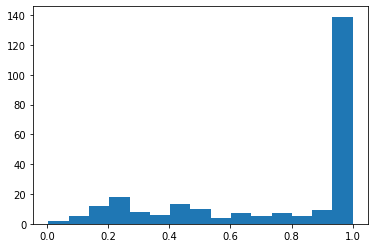

In [61]:
def p_K(scores):
    return (scores > 0).sum()/scores.size

def ap_K(scores):
    return (np.cumsum(scores > 0)/np.arange(1, scores.size+1)).sum()/scores.size

def map_K(matrix, K, count=1000):
    ap = []
    ids = np.random.permutation(np.arange(matrix.shape[0]))[:count]
    for uid in tqdm(ids):
        goods = get_top_games(uid, 15, K, rates_matrix=matrix,
                              verbose=False, exclude_played=False)
        ap.append(ap_K(matrix[uid, goods]))
    return np.mean(ap), ap

map_5, aps = map_K(user_item, 5, count=250)
print('map@5: ', map_5)
map_10, aps = map_K(user_item, 10, count=250)
print('map@10: ', map_10)
map_25, aps = map_K(user_item, 25, count=250)
print('map@25: ', map_25)
plt.hist(aps, bins=15)

## Метод на основе сингулярного разложения

In [62]:
%%time
U, S, VT = np.linalg.svd(user_item.T)
V = VT.T

CPU times: user 8min 28s, sys: 27.1 s, total: 8min 55s
Wall time: 2min 19s


In [63]:
Sigma = np.diag(S)
Sigma.shape

(5155, 5155)

In [176]:
# Используем 50 первых сингулярных значения
r = 50
Ur = U[:, :r]
Sr = Sigma[:r, :r]
Vr = V[:, :r]

In [195]:
def get_top_games_svd(user_id, k=15, top_n=5,
                  rates_matrix=user_item, exclude_played=True,
                  verbose=True):
    # Вычисляем косинусную близость между текущим пользователем 
    # и остальными пользователями
    test_user_result = np.mat(rates_matrix[user_id:user_id+1]) * Ur * np.linalg.inv(Sr)
    test_user_result = np.array(test_user_result[0,:])
    cos_sim = cosine_similarity(Vr, test_user_result.reshape(1, -1))
    # Преобразуем размерность массива
    cos_sim_list = cos_sim.reshape(-1, cos_sim.shape[0])[0]
    # Находим наиболее близкого пользователя
    recommended_user_id = np.argsort(-cos_sim_list)[1:k+1]
    goods_score = rates_matrix[recommended_user_id].mean(axis=0)
    goods = np.where(goods_score>0)[0]
    if exclude_played:
        indexes = list(set(goods).difference(np.where(rates_matrix[user_id]>0)[0]))
    else:
        indexes = list(goods)
    count = 1
    results = []
    for index in sorted(indexes, key=lambda x: -goods_score[x]):
        if verbose:
            print(goods_score[index], ndf[ndf.game_id==index].game.iloc[0])
        count += 1
        results.append(index)
        if count > top_n:
            break
    if verbose:
        print('-'*50)
    return results

get_top_games_svd(1, 15, 10, exclude_played=False)
get_top_games_svd(1, 15, 10, exclude_played=True)

8.499555713752548 Call of Duty Ghosts
7.093351136032569 FIFA Manager 11
7.093350779897767 Kings of Kung Fu
6.217725798087599 Call of Duty Black Ops II
5.708438581580046 Act of Aggression
5.343728421991114 Empire Total War
5.033951082394444 R.U.S.E
4.8218532854862675 Call of Duty Advanced Warfare
4.578137919157043 Silent Hunter 5 Battle of the Atlantic
4.457495346219281 Napoleon Total War
--------------------------------------------------
8.499555713752548 Call of Duty Ghosts
7.093351136032569 FIFA Manager 11
7.093350779897767 Kings of Kung Fu
6.217725798087599 Call of Duty Black Ops II
5.708438581580046 Act of Aggression
5.343728421991114 Empire Total War
5.033951082394444 R.U.S.E
4.8218532854862675 Call of Duty Advanced Warfare
4.578137919157043 Silent Hunter 5 Battle of the Atlantic
4.457495346219281 Napoleon Total War
--------------------------------------------------


[734, 1608, 2408, 730, 104, 1499, 3355, 724, 3838, 2896]

  0%|          | 0/2500 [00:00<?, ?it/s]

map@5:  0.6778946666666666


  0%|          | 0/2500 [00:00<?, ?it/s]

map@10:  0.6755319206349206


  0%|          | 0/2500 [00:00<?, ?it/s]

map@25:  0.7006449681622653


(array([ 162.,  142.,  116.,  111.,   81.,   59.,   45.,   65.,   74.,
          75.,   74.,  111.,   88.,   72., 1225.]),
 array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
        0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
        0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
        1.        ]),
 <BarContainer object of 15 artists>)

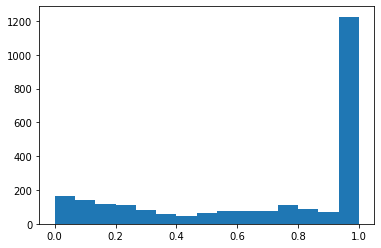

In [193]:
def map_K_svd(matrix, K, count=1000):
    ap = []
    ids = np.random.permutation(np.arange(matrix.shape[0]))[:count]
    for uid in tqdm(ids):
        goods = get_top_games_svd(uid, 15, K, rates_matrix=matrix,
                                  verbose=False, exclude_played=False)
        ap.append(ap_K(matrix[uid, goods]))
    return np.mean(ap), ap

map_5, aps = map_K_svd(user_item, 5, count=2500)
print('map@5: ', map_5)
map_10, aps = map_K_svd(user_item, 10, count=2500)
print('map@10: ', map_10)
map_25, aps = map_K_svd(user_item, 25, count=2500)
print('map@25: ', map_25)
plt.hist(aps, bins=15)

# Выводы

|                 | KNN | SVD |
|-----------------|--------------|----------------|
| map@5 | 0.8377      | 0.6779         |
| map@10 | 0.8078       | 0.6755         |
| map@25 | 0.7548       | 0.7006       |
| скорость, рек/c | 2.28       | 94.29      |

SVD разложение уступает по качеству методу рекомендаций пользователь-пользователь на ~15%, однако быстрее последнего в ~40 раз